In [162]:
import matplotlib.pyplot as plt

%matplotlib inline

In [247]:
import pandas as pd
import numpy as np
import networkx as nx

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import numpy as np
from gensim.models import Word2Vec, KeyedVectors
from datetime import datetime, date, time
from itertools import *
import time

In [216]:
def shuffle(data):
    for i in range(len(data)):
        j = np.random.randint(i, high=len(data))
        tmp = data[j]
        data[j] = data[i]
        data[i] = tmp

In [217]:
df = pd.read_csv('clicks_hashed.csv')[:10000]
df.head()

,id,Click time,Ad id,Advertiser id,Site id,User id,User IP
0,0,1406977042,a3fbcd7e4b6362c75ab56687116a2433,510885b9a863ce0bd84b2ed3e58398f9,f9f32862920f6ca00c9725eade88f3d9,36b51acc9d3250851d0c0114aa04cc46,b1c7ac8696898d6f799e2f64c94156e6
1,1,1406977012,8683b0a8e3b4cac34cb40821e498ccdc,78ee95b2e2a854b40c714656b3f4321f,aa8e410642c0a8b95c53ea98a45c90b2,c6b363b3302908d1d6046d080df839e4,fd5cc76d2bfe24099c8777d557524b45
2,2,1406976966,8f8670b832c00cfd8493bca779aba942,e4551b0407c1cd88b24d367fc1ba4c5a,67877aff2349aa3053210af23632428f,0f2918a022fde0225b535988734461c4,39db42ae552c7c52dff1eb45d097bcab
3,3,1406976910,3437653362b4fab85ca9e147230208c5,478fb38eaeca30e36e1394411b2282a2,67877aff2349aa3053210af23632428f,bc605147700345892e6307ddfb4dedb6,10aa7a94cd916c9c6c1fa8c4cf22c92d
4,4,1406976857,a7e94defddbea68fb8cbc0885829a8b2,fcf373d8127ff67ac5501de0f6f80ec3,d2373599997dca05b50ade27578b8251,c32870919f9270d120cd58d68a957c18,0b0cad9116bb30d043be878866accd40


In [240]:
timestamp = df['Click time']
max_gap = max(timestamp) - min(timestamp)
d = timedelta(seconds=max_gap)
d.days, d.seconds

(0, 5314)

In [219]:
nx_graph = nx.MultiGraph()
n_cols = len(df.columns)
user_col = df.columns[-2]
site_col = df.columns[-3]
for row in df.itertuples():
    vals_with_col_names = ['{}_{}'.format(df.columns[i], row[i + 1]) for i in range(len(df.columns))]
    user = vals_with_col_names[5]
    advertiser = vals_with_col_names[3]
    site = vals_with_col_names[4]
    for i in range(4, 6):
        nx_graph.add_node(vals_with_col_names[i], label=df.columns[i])
        
    nx_graph.add_edge(user, site, time=row[2])

In [220]:
labels = nx.get_node_attributes(nx_graph, 'label')

In [221]:
def inc(dic, key, val):
    if key not in dic:
        dic[key] = []
    dic[key].append(val)

In [222]:
def tail_of_sorted(dic, num, rev):
    cur_tail = set()
    last_key = None
    for key in sorted(dic.keys(), reverse=rev):
        remainder = max(0, num - len(cur_tail))
        if remainder > 0:
            last_key = key
            cur_tail |= set(dic[key][:remainder])
        else:
            break
    return cur_tail, last_key

In [223]:
clicks_to_node, duplicates_to_node, gap_to_node = {}, {}, {}
for node in nx_graph.node:
    if labels[node] == user_col:
        clicks = nx_graph.degree(node)
        inc(clicks_to_node, clicks, node)
        
        max_duplicates = 0
        max_gap = -1
        for neighbor in nx_graph.neighbors(node):
            edge_data = nx_graph.get_edge_data(node, neighbor)
            timestamps = sorted([edge_data[neigh]['time'] for neigh in edge_data])
            if len(timestamps) > 1:
                max_gap = max(max_gap, max([timestamps[i] - timestamps[i - 1] for i in range(1, len(timestamps))]))
            max_duplicates = max(max_duplicates, len(timestamps))
            
        inc(duplicates_to_node, max_duplicates, node)
        if max_gap >= 0:
            inc(gap_to_node, max_gap, node)
        

In [224]:
clicks_tail, _ = tail_of_sorted(clicks_to_node, 100, True)
duplicates_tail, _ = tail_of_sorted(duplicates_to_node, 100, True)
gaps_tail, gap = tail_of_sorted(gap_to_node, 100, False)

gap

14

In [225]:
outliers = clicks_tail | duplicates_tail | gaps_tail
len(outliers)

220

In [226]:
mg = nx.MultiGraph()
mg.add_edge(1, 2)
mg.add_edge(1, 2)
mg.add_edge(1, 2, time=123)
mg.add_edge(1, 3, time=123)
print(mg.degree(1))
mg.get_edge_data(1, 2).values()
# for xx in mg.neighbors(2):
#     print(xx)

# mg.


4


dict_values([{}, {}, {'time': 123}])

In [227]:
def get_degrees_by_label(nodes):
    degrees_by_label = dict([(col, []) for col in df.columns[2:6]])
    
    deg = nx_graph.degree
    for node in nodes:
        label = labels[node]
        degrees_by_label[labels[node]].append(nx_graph.degree(node))

    return degrees_by_label

In [228]:
def plot_degree_hist(nodes):
    plt.figure(figsize=(20,16))
    
    degrees_by_label = get_degrees_by_label(nodes)
    for i, col in enumerate(df.columns[3:6]):
        degrees = np.array(degrees_by_label[col])
        print(col, 'mean: ', degrees.mean(), 'median: ', np.median(degrees))
        ax = plt.subplot(2, 2, i + 1)
        ax.set_title(col)
        plt.hist(np.array(degrees), bins=40, density=True)
        

/home/roman/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/home/roman/.local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/roman/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/roman/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Advertiser id mean:  nan median:  nan
Site id mean:  26.666666666666668 median:  4.0
User id mean:  1.1786892975011787 median:  1.0


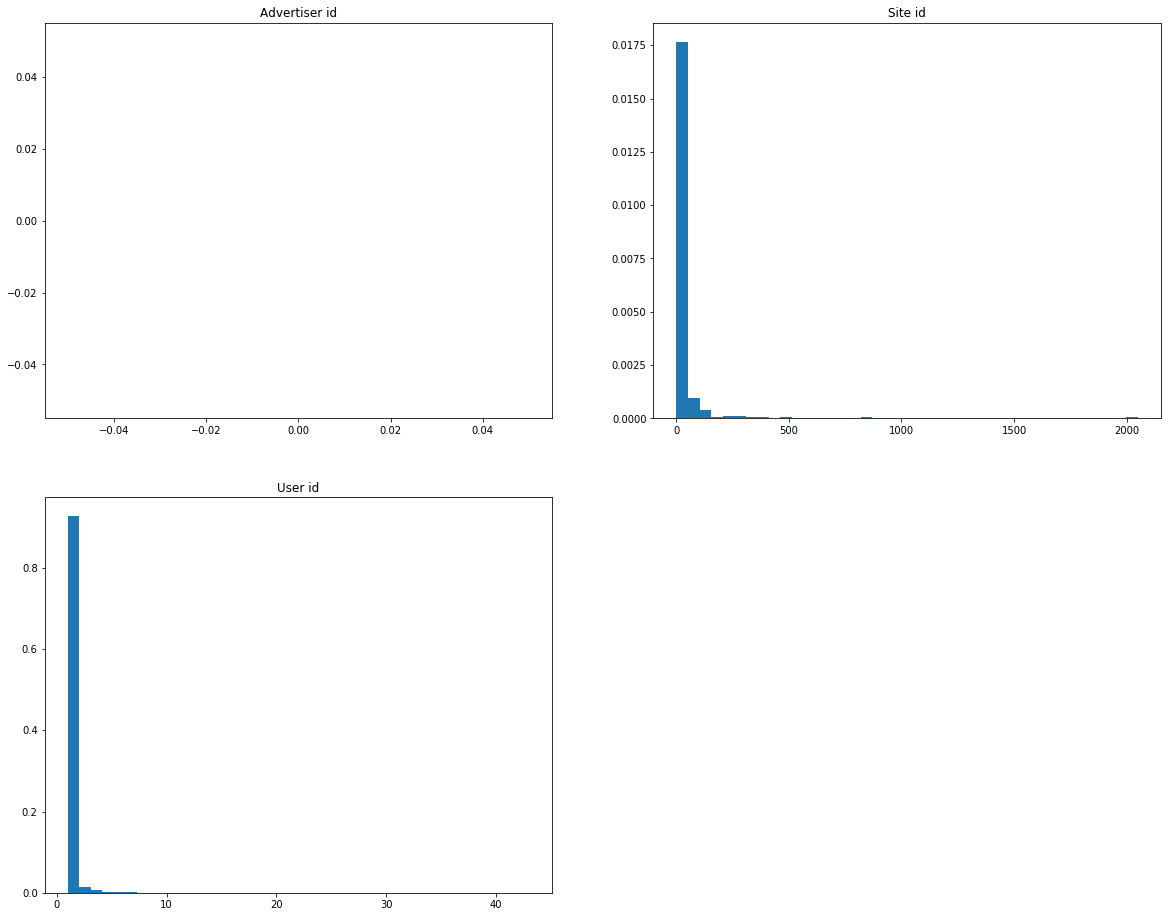

In [229]:
plot_degree_hist(nx_graph.nodes)

In [252]:
metapaths = [
    ["User id", "Site id"]
#     ["User id", "Advertiser id"],
#     ["Advertiser id", "Ad id", "Site id", "Ad id", "Advertiser id"]
]

In [231]:
def visualize(embeddings, color):
    tsne = TSNE(random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    ax = plt.gca()
    ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color=color)

In [232]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

In [233]:
def print_embeddings(wv):
    for w in wv.index2word:
        print(w, wv[w])

In [234]:
test_path = 'test/fest'
model = Word2Vec([['ab', 'cd'], ['ef', 'gh']], size=12, window=5, min_count=0, sg=1, workers=2, iter=1)
print_embeddings(model.wv)
model.wv.save(test_path)


ab [-0.03302584  0.02807255 -0.02034169 -0.01868852 -0.03655759  0.03733052
  0.01499179 -0.01892737 -0.02919713  0.02912121  0.00539309  0.00179358]
cd [ 0.0158291   0.00348992 -0.00337256 -0.004869   -0.00822682 -0.00757282
  0.03373738 -0.01886186  0.01308674  0.0061597  -0.01581526 -0.01167588]
ef [ 0.02754328  0.00720795  0.02028308 -0.03608489  0.02636644  0.02296141
  0.03394622 -0.03097611  0.00456259 -0.02038387 -0.01893904 -0.01704763]
gh [-0.00217897  0.01762091 -0.01134779  0.02878012  0.00888268 -0.03875111
  0.04006844  0.03753015 -0.02503809 -0.03540228  0.00653189  0.01997325]


In [235]:
print_embeddings(KeyedVectors.load(test_path, mmap='r'))


ab [-0.03302584  0.02807255 -0.02034169 -0.01868852 -0.03655759  0.03733052
  0.01499179 -0.01892737 -0.02919713  0.02912121  0.00539309  0.00179358]
cd [ 0.0158291   0.00348992 -0.00337256 -0.004869   -0.00822682 -0.00757282
  0.03373738 -0.01886186  0.01308674  0.0061597  -0.01581526 -0.01167588]
ef [ 0.02754328  0.00720795  0.02028308 -0.03608489  0.02636644  0.02296141
  0.03394622 -0.03097611  0.00456259 -0.02038387 -0.01893904 -0.01704763]
gh [-0.00217897  0.01762091 -0.01134779  0.02878012  0.00888268 -0.03875111
  0.04006844  0.03753015 -0.02503809 -0.03540228  0.00653189  0.01997325]


In [236]:
model.wv.index2word

['ab', 'cd', 'ef', 'gh']

In [237]:
from pathlib import Path

In [239]:
before = time.time()
model = Word2Vec(walks, size=12, window=5, min_count=0, sg=1, workers=2, iter=1)
after = time.time()
print('word2vec', after - before, 's')
word_vectors = model.wv
vector_file = datetime.isoformat(datetime.now(), timespec='seconds')
model.wv.save('saved/' + vector_file)

AttributeError: 'Series' object has no attribute 'time'

In [256]:
def get_walks(nodes, graph, length, walks_per_node, metapaths):
    walks = []
    for node in nodes:
        filtered_metapaths = [metapath for metapath in metapaths if metapath[0] == graph.node[node]['label']]
        for metapath in filtered_metapaths:
            for walk_number in range(walks_per_node):
                walk = [node]
                walk_time_sum = 0
                current_node = node
                for i in range(length - 1):
                    neighbour_timedeltas = []
                    for neighbour in graph.neighbors(current_node):
                        if graph.node[neighbour]['label'] == metapath[(i + 1) % len(metapath)]:
                            for possible_edge in graph.get_edge_data(neighbour, walk[-1]).values():
                                if len(walk) >= 2:
                                    walk_time_avg = walk_time_sum / (len(walk) - 1)
#                                     print(walk_time_avg)
                                    timedelta_seconds = abs(walk_time_avg - possible_edge['time'])
                                else:
                                    timedelta_seconds = 0

                                neighbour_timedeltas.append((neighbour, timedelta_seconds))
                    if len(neighbour_timedeltas) == 0:
                        break
                    else:
                        neighbour_timedeltas.sort(key=lambda x: x[1])
                        rand_ix = np.random.randint(0, high=max(len(neighbour_timedeltas) // 2, 1))
                        current_node, timedelta_seconds = neighbour_timedeltas[rand_ix]
                        
                    walk.append(current_node)
                    walk_time_sum += timedelta_seconds
                
#                 print(walk)
                walks.append(walk)
    return walks

In [258]:
walks[:5]

[['User id_36b51acc9d3250851d0c0114aa04cc46',
  'Site id_f9f32862920f6ca00c9725eade88f3d9',
  'User id_36bce9fdfe9034c9a4982caf0cb82230',
  'Site id_f9f32862920f6ca00c9725eade88f3d9',
  'User id_ed4baff440438a37041897c84b77c417'],
 ['User id_c6b363b3302908d1d6046d080df839e4',
  'Site id_aa8e410642c0a8b95c53ea98a45c90b2',
  'User id_46ca3482a83ac086b1cdc45a7415a72a',
  'Site id_aa8e410642c0a8b95c53ea98a45c90b2',
  'User id_fb72da1bb6c9b926de17fb37008aa101'],
 ['User id_0f2918a022fde0225b535988734461c4',
  'Site id_67877aff2349aa3053210af23632428f',
  'User id_3da7d25ada4b0bdf06347ff9dd3440c2',
  'Site id_67877aff2349aa3053210af23632428f',
  'User id_b221d344b125ddb47693bba3ba295b18'],
 ['User id_bc605147700345892e6307ddfb4dedb6',
  'Site id_67877aff2349aa3053210af23632428f',
  'User id_29ba6036205ee48b0ca7fba12b389564',
  'Site id_67877aff2349aa3053210af23632428f',
  'User id_f474333dd805af4d3fbd64b3691f2b7c'],
 ['User id_c32870919f9270d120cd58d68a957c18',
  'Site id_d2373599997dca05b50

In [243]:
latest_vector_file = None
if Path('saved').exists():
    embedding_files = [f for f in Path('saved').iterdir()]
    if len(embedding_files) > 0:
        latest_vector_file = 'saved/' + max(embedding_files, key=lambda f: f.name).name
print(latest_vector_file)

None


In [257]:
if latest_vector_file is not None:
    word_vectors = KeyedVectors.load(latest_vector_file, mmap='r')
else:
    word_vectors = None
    before = time.time()
    walks = get_walks(list(nx_graph.nodes()), nx_graph, 5, 1, metapaths)
    after = time.time()
    print('walks', after - before, 's')
    print('Len ', len(walks))
    before = time.time()
    model = Word2Vec(walks, size=12, window=5, min_count=0, sg=1, workers=2, iter=1)
    after = time.time()
    print('word2vec', after - before, 's')
    word_vectors = model.wv
    vector_file = datetime.isoformat(datetime.now(), timespec='seconds')
    model.wv.save('saved/' + vector_file)

walks 131.56919026374817 s
Len  8484
word2vec 1.2388684749603271 s


In [ ]:
KeyedVectors.load('saved/2018-12-16T14:37:50')

In [255]:
metapaths[0]

['User id', 'Site id']

In [ ]:
print(latest_vector_file)

In [ ]:
node_embeddings = [(n, word_vectors[n]) for n in word_vectors.index2word if n.startswith('User')]

In [ ]:
len(node_embeddings)

In [ ]:
print(len(node_embeddings))
outlier_embeddings, inlier_embeddings = [], []
for node, emb in node_embeddings:
    if node in outliers:
        outlier_embeddings.append((node, emb))
    else:
        inlier_embeddings.append((node, emb))

In [ ]:
plt.imshow([node2emb[1] for node2emb in outlier_embeddings][:10] + [node2emb[1] for node2emb in inlier_embeddings][:10])
plt.colorbar()
plt.show()

In [ ]:
plt.matshow([node2emb[1] for node2emb in inlier_embeddings][:50])
plt.colorbar()